# ICR - Identifying Age-Related Conditions Dataset with YDF

This notebook walks you through how to train a baseline Random Forest model using YDF (Yggdrasil Decision Forests) on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import ydf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
model = ydf.RandomForestLearner(label="my_label").train(dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [64]:
import ydf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss


In [65]:
print("YDF v" + ydf.__version__)


YDF v0.15.0


# Load the Dataset

In [66]:
dataset_df = pd.read_csv('../data/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [67]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [68]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


## Pie chart for label column: Class

<Axes: >

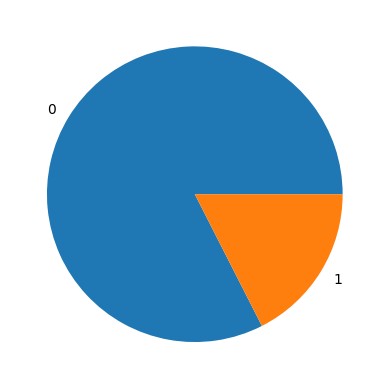

In [69]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

In [70]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

Let us now plot the first 6 numerical columns and their values using bar charts.

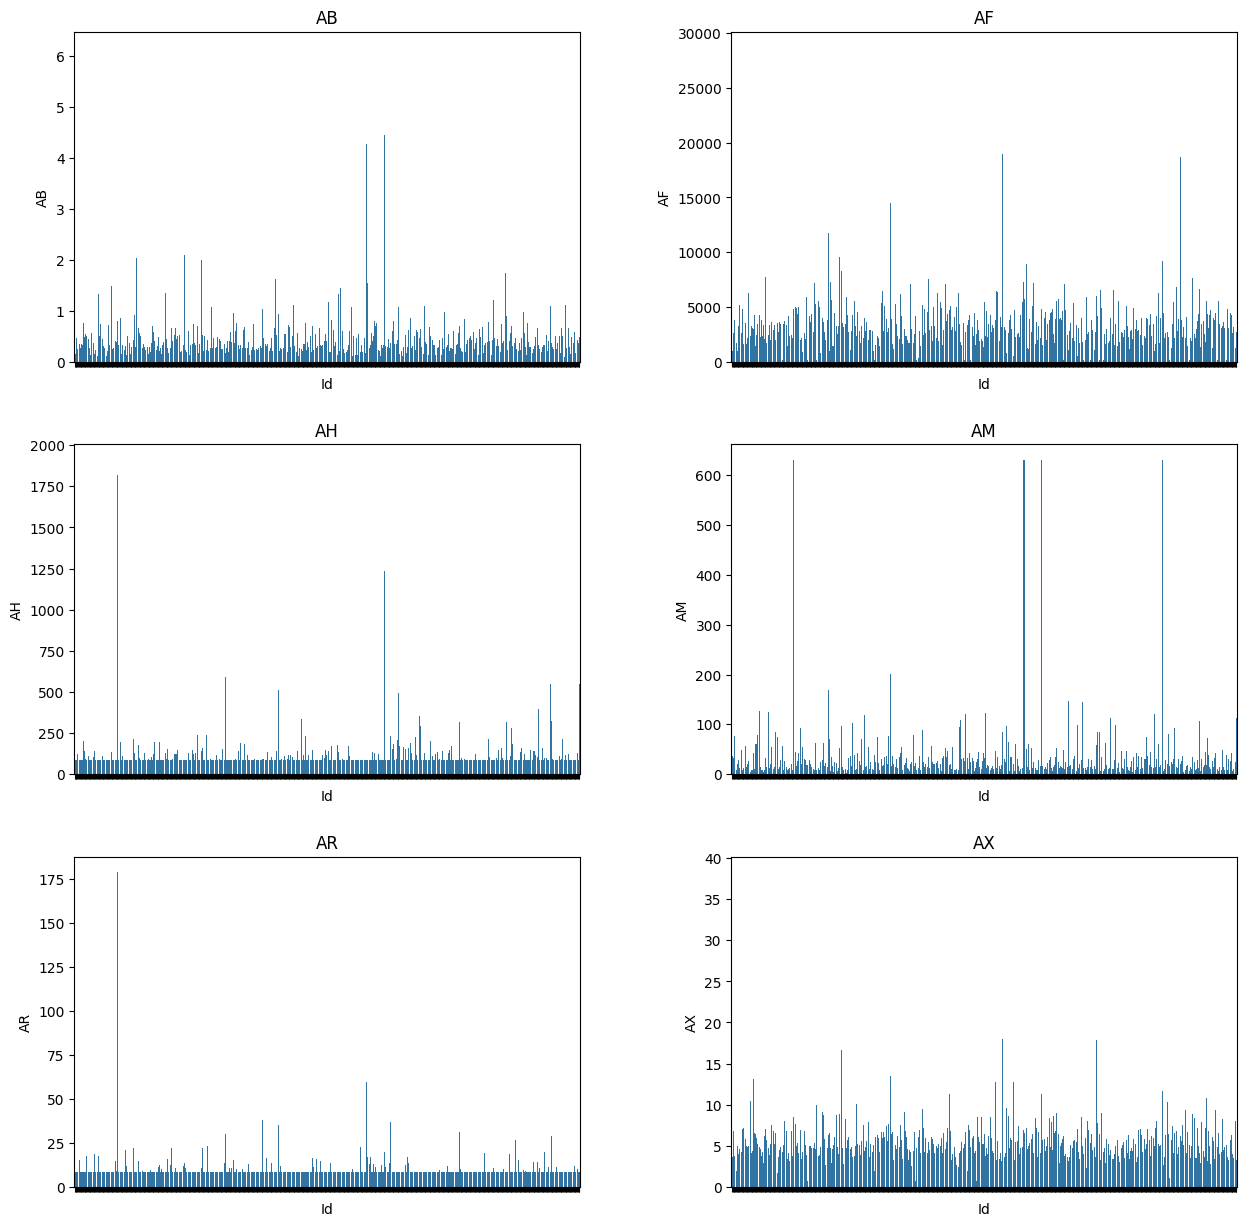

In [71]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [72]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

Now let us split the dataset into training and testing datasets:

# KFold validation

We will use KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [73]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [74]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in YDF using the following code:

In [75]:
print("Using YDF learners: RandomForestLearner, GradientBoostedTreesLearner, CartLearner")


Using YDF learners: RandomForestLearner, GradientBoostedTreesLearner, CartLearner


# How can I configure them?

YDF provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

```rf = ydf.RandomForestLearner(label="Class")```

Read more [here](https://ydf.readthedocs.io).

# Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training.
Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute`max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`).

You can set these parameters as follows:

```rf = ydf.RandomForestLearner(label="Class", max_depth=5, num_trees=500)```

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [76]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **class weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [77]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```ydf.RandomForestLearner(label="Class").train(train_df)```

# Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [78]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
    print('##### Fold', i + 1)

    # Fetch values corresponding to the index
    train_df = dataset_df.iloc[train_index][FEATURE_COLUMNS].copy()
    valid_df = dataset_df.iloc[valid_index][FEATURE_COLUMNS].copy()
    valid_ids = valid_df.index.values

    # Split features / label for evaluation and prediction.
    X_valid = valid_df.drop(columns=[label])
    y_true = valid_df[label].astype(int).values

    # Optional: carry over class_weight by creating per-row sample weights.
    train_df['sample_weight'] = train_df[label].map(class_weight).astype(float)

    # YDF trains directly on pandas DataFrames.
    rf = ydf.RandomForestLearner(label=label, weights='sample_weight').train(train_df)

    # Store the model
    models[f"fold_{i+1}"] = rf

    # Predict OOF probabilities for validation data
    predict = np.asarray(rf.predict(X_valid), dtype=float).reshape(-1)
    predict = np.clip(predict, 1e-7, 1 - 1e-7)

    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict

    # Evaluate and store the metrics in respective dicts
    y_pred_label = (predict >= 0.5).astype(int)
    accuracy[f"fold_{i+1}"] = accuracy_score(y_true, y_pred_label)
    cross_entropy[f"fold_{i+1}"] = log_loss(y_true, predict)


##### Fold 1
Train model on 493 examples


Model trained in 0:00:00.061454
##### Fold 2
Train model on 493 examples
Model trained in 0:00:00.048169
##### Fold 3
Train model on 494 examples
Model trained in 0:00:00.048335
##### Fold 4
Train model on 494 examples
Model trained in 0:00:00.047833
##### Fold 5
Train model on 494 examples
Model trained in 0:00:00.046527


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [79]:
print("Tree visualization via model-specific visualization tools is not available after switching to YDF.")


Tree visualization via model-specific visualization tools is not available after switching to YDF.


# Evaluate the model on the validation folds

After training, we compare fold-wise validation metrics.
This is the most direct quality check for the current YDF pipeline.


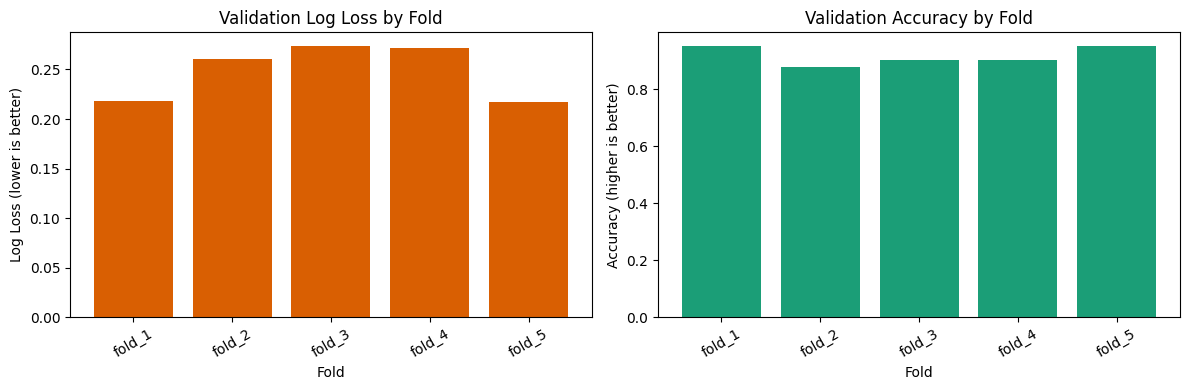

In [80]:
fold_names = list(models.keys())
losses = [cross_entropy[f] for f in fold_names]
accs = [accuracy[f] for f in fold_names]

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].bar(fold_names, losses, color='#d95f02')
axis[0].set_title('Validation Log Loss by Fold')
axis[0].set_xlabel('Fold')
axis[0].set_ylabel('Log Loss (lower is better)')
axis[0].tick_params(axis='x', rotation=30)

axis[1].bar(fold_names, accs, color='#1b9e77')
axis[1].set_title('Validation Accuracy by Fold')
axis[1].set_xlabel('Fold')
axis[1].set_ylabel('Accuracy (higher is better)')
axis[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


We can also print the fold metrics in tabular form:


In [81]:
metrics_df = pd.DataFrame({
    'fold': list(models.keys()),
    'accuracy': [accuracy[f] for f in models.keys()],
    'log_loss': [cross_entropy[f] for f in models.keys()]
})

display(metrics_df)


,fold,accuracy,log_loss
0,fold_1,0.951613,0.218250
1,fold_2,0.879032,0.260758
2,fold_3,0.902439,0.273778
3,fold_4,0.902439,0.271665
4,fold_5,0.951220,0.216923


Now, let us check the evaluation metrics for each fold and its average value.

In [82]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2183
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2738
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2169

Average accuracy: 0.9173  Average loss: 0.2483


# Variable importances

To stay library-agnostic, we estimate feature importance with permutation importance
on fold 1 validation data and measure the increase in log loss.


In [83]:
# Recreate fold 1 validation split
first_train_idx, first_valid_idx = next(kf.split(X=dataset_df))
fold1_valid_df = dataset_df.iloc[first_valid_idx][FEATURE_COLUMNS].copy()
X_valid_fold1 = fold1_valid_df.drop(columns=[label])
y_valid_fold1 = fold1_valid_df[label].astype(int).values

model = models['fold_1']
base_pred = np.asarray(model.predict(X_valid_fold1), dtype=float).reshape(-1)
base_pred = np.clip(base_pred, 1e-7, 1 - 1e-7)
base_loss = log_loss(y_valid_fold1, base_pred)

rng = np.random.default_rng(42)
importances = {}
for col in X_valid_fold1.columns:
    shuffled = X_valid_fold1.copy()
    shuffled[col] = rng.permutation(shuffled[col].values)
    pred = np.asarray(model.predict(shuffled), dtype=float).reshape(-1)
    pred = np.clip(pred, 1e-7, 1 - 1e-7)
    importances[col] = log_loss(y_valid_fold1, pred) - base_loss

importance_df = (
    pd.DataFrame({'feature': list(importances.keys()), 'importance': list(importances.values())})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print(f'Baseline fold_1 log loss: {base_loss:.5f}')
importance_df.head(20)


Baseline fold_1 log loss: 0.21825


,feature,importance
0,DU,0.061327
1,AB,0.023913
2,CR,0.013769
3,GL,0.012375
4,BQ,0.011150
5,FL,0.009844
6,DI,0.009011
7,DA,0.008894
8,AF,0.006957
9,FR,0.006828


Larger positive values mean stronger degradation when the feature is shuffled,
so those features are more important for predictions.


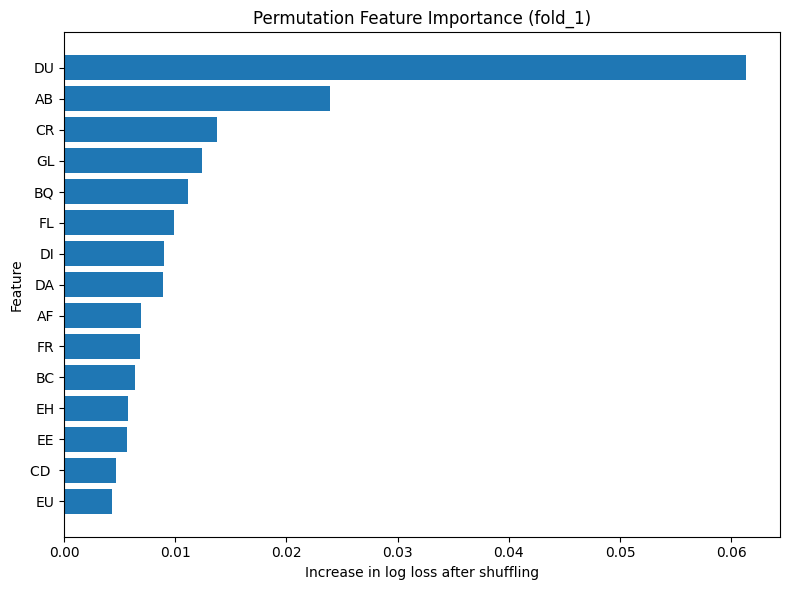

In [84]:
top_n = 15
plot_df = importance_df.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(plot_df['feature'], plot_df['importance'])
plt.title('Permutation Feature Importance (fold_1)')
plt.xlabel('Increase in log loss after shuffling')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Submission

In [85]:
test_df = pd.read_csv('../data/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
predictions = np.asarray(models['fold_1'].predict(test_ds_pd))
if predictions.ndim == 2:
    predictions = predictions[:, 1] if predictions.shape[1] > 1 else predictions[:, 0]
predictions = np.clip(predictions.astype(float).flatten(), 1e-7, 1 - 1e-7)
n_predictions= [[round(1 - i, 8), round(i, 8)] for i in predictions]
print(n_predictions)


[[np.float64(0.65333357), np.float64(0.34666643)], [np.float64(0.65333357), np.float64(0.34666643)], [np.float64(0.65333357), np.float64(0.34666643)], [np.float64(0.65333357), np.float64(0.34666643)], [np.float64(0.65333357), np.float64(0.34666643)]]


In [88]:
sample_submission = pd.read_csv("/root/AI-Biomedicine/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/data/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/root/AI-Biomedicine/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/data/sample_submission.csv', index=False)